In [1]:
# from __future__ import print_function
from IPython.display import display
from pycocotools.coco import COCO
import sys
import os
import urllib.request
import zipfile
import shutil
import numpy as np
import skimage.io as io
import matplotlib
import matplotlib.pyplot as plt
import pylab
import pathlib
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline

In [2]:
# Record package versions for reproducibility

print("os: %s" % os.name)
print("sys: %s" % sys.version)
print("numpy: %s, %s" % (np.__version__, np.__file__))

print("matplotlib backend: ", matplotlib.get_backend())

notebook_dir = os.path.abspath('')
print("notebook_dir =", notebook_dir)

# project_dir = os.path.abspath(os.path.join(os.path.dirname(notebook_dir), "..", ".."))
# print(project_dir)
# sys.path.insert(0, project_dir)

os: nt
sys: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy: 1.20.1, D:\Software\anaconda3\envs\rnd\lib\site-packages\numpy\__init__.py
matplotlib backend:  module://ipykernel.pylab.backend_inline
notebook_dir = D:\Workspace\git\RnDProject\cocoapi\src


In [13]:
# dataDir='..'
# dataType='val2017'
# annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Setup data paths
dataDir = os.path.abspath('../data/coco')
year = "2017"
dataType = 'train{}'.format(year)

annDir = os.path.join(dataDir, 'annotations')
# annZipFile = os.path.join(dataDir, 'annotations_trainval{}.zip'.format(year))
annFile = os.path.join(annDir, 'instances_{}.json'.format(dataType))
# annURL = 'http://images.cocodataset.org/annotations/annotations_train{}.zip'.format(dataType)
print(annDir)
print(annFile)

D:\Workspace\git\RnDProject\cocoapi\data\coco\annotations
D:\Workspace\git\RnDProject\cocoapi\data\coco\annotations\instances_train2017.json


In [14]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=29.75s)
creating index...
index created!


In [15]:
# dir(coco)

In [16]:
coco.info()

description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01


In [17]:
cat_indices = coco.getCatIds()
cats = sorted(coco.loadCats(cat_indices), key=lambda x: x["id"])
# display(cats)
print(cats[0])
print(f"COCO categories with indices: {len(cats)}")
for c in cats:
    print(f"{c['id']:2} --- {c['name']}")



{'supercategory': 'person', 'id': 1, 'name': 'person'}
COCO categories with indices: 80
 1 --- person
 2 --- bicycle
 3 --- car
 4 --- motorcycle
 5 --- airplane
 6 --- bus
 7 --- train
 8 --- truck
 9 --- boat
10 --- traffic light
11 --- fire hydrant
13 --- stop sign
14 --- parking meter
15 --- bench
16 --- bird
17 --- cat
18 --- dog
19 --- horse
20 --- sheep
21 --- cow
22 --- elephant
23 --- bear
24 --- zebra
25 --- giraffe
27 --- backpack
28 --- umbrella
31 --- handbag
32 --- tie
33 --- suitcase
34 --- frisbee
35 --- skis
36 --- snowboard
37 --- sports ball
38 --- kite
39 --- baseball bat
40 --- baseball glove
41 --- skateboard
42 --- surfboard
43 --- tennis racket
44 --- bottle
46 --- wine glass
47 --- cup
48 --- fork
49 --- knife
50 --- spoon
51 --- bowl
52 --- banana
53 --- apple
54 --- sandwich
55 --- orange
56 --- broccoli
57 --- carrot
58 --- hot dog
59 --- pizza
60 --- donut
61 --- cake
62 --- chair
63 --- couch
64 --- potted plant
65 --- bed
67 --- dining table
70 --- toilet

In [18]:
supercat_names = set([c["supercategory"] for c in cats])
print("COCO supercategories: {}\n{}\n".format(
    len(supercat_names),
    ", ".join(supercat_names)
))

print("Number of categories per supercategory:")
for name in supercat_names:
    c_ids = coco.getCatIds(supNms=name)
    c_nms = [c["name"] for c in coco.loadCats(c_ids)]
    print("{:>12}({:>2}) -> {}".format(
        name,
        len(c_nms),
        ", ".join(c_nms)
))
print()

print(f"Total number of images in {dataType}: {len(coco.getImgIds())}")
print(f"Total number of annotations in {dataType}: {len(coco.getAnnIds())}")


print("Number of images per category:")
for name in supercat_names:
    subcat_ids = coco.getCatIds(supNms=name)
    subcat_nms = [c["name"] for c in coco.loadCats(subcat_ids)]
    subcat_image_counts = [len(coco.getImgIds(catIds=id)) for id in subcat_ids]
    cat_counts = ', '.join([f"{subcat_nm}({image_count})" for subcat_nm, image_count in zip(subcat_nms, subcat_image_counts)])
    print("{:>12}({}) -> {}".format(
        name,
        sum(subcat_image_counts),
        cat_counts
    ))


COCO supercategories: 12
animal, electronic, vehicle, kitchen, sports, food, indoor, person, accessory, furniture, appliance, outdoor

Number of categories per supercategory:
      animal(10) -> bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe
  electronic( 6) -> tv, laptop, mouse, remote, keyboard, cell phone
     vehicle( 8) -> bicycle, car, motorcycle, airplane, bus, train, truck, boat
     kitchen( 7) -> bottle, wine glass, cup, fork, knife, spoon, bowl
      sports(10) -> frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket
        food(10) -> banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake
      indoor( 7) -> book, clock, vase, scissors, teddy bear, hair drier, toothbrush
      person( 1) -> person
   accessory( 5) -> backpack, umbrella, handbag, tie, suitcase
   furniture( 6) -> chair, couch, potted plant, bed, dining table, toilet
   appliance( 5) -> microwave, oven, toast

## Statistics

In [19]:
RESULT_DIR = os.path.normpath("../results/statistics")
PLOT_DIR = os.path.join(RESULT_DIR, "plots")

pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

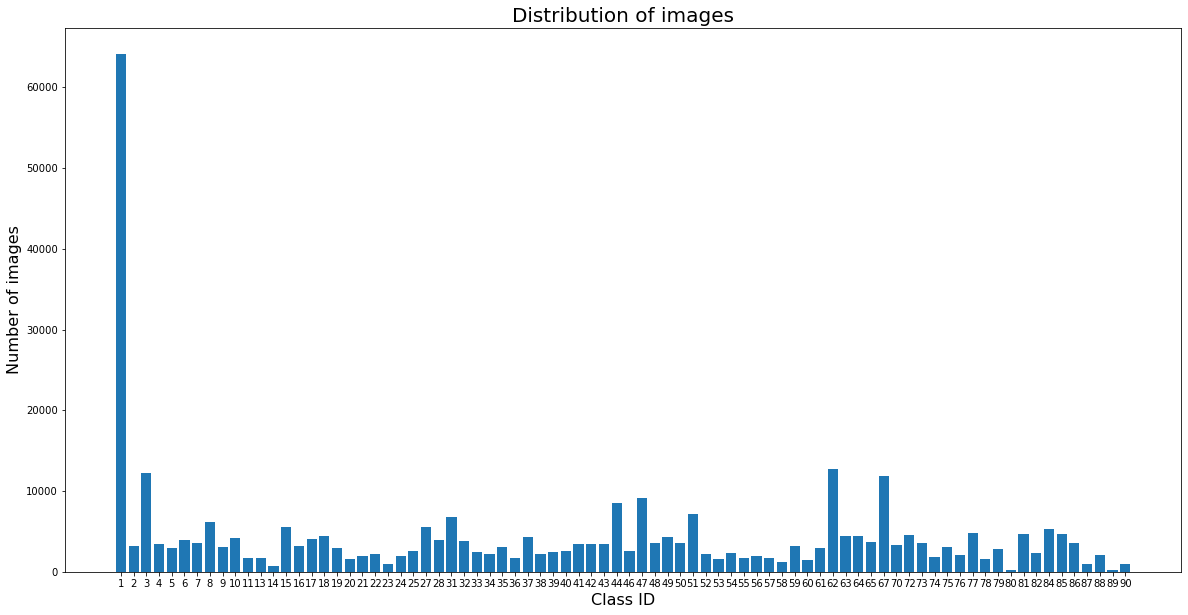

In [20]:
subcat_indices = []
subcat_names = []
subcat_image_counts = []
for name in supercat_names:
    s_ids = coco.getCatIds(supNms=name)
    subcat_indices.extend(s_ids)
    subcat_names.extend([c["name"] for c in coco.loadCats(s_ids)])
    subcat_image_counts.extend([len(coco.getImgIds(catIds=id)) for id in s_ids])
    
subcat_indices, subcat_names, subcat_image_counts = zip(*sorted(zip(subcat_indices, subcat_names, subcat_image_counts), key=lambda x: x[0]))

    
assert len(subcat_indices) == len(subcat_image_counts), f"{len(subcat_ids)}, {len(subcat_image_counts)}"
assert len(subcat_indices) == len(subcat_names), f"{len(subcat_ids)}, {len(subcat_names)}"

plt.figure(figsize=(20, 10))
plt.title("Distribution of images", fontsize=20)
plt.bar([str(x) for x in subcat_indices], subcat_image_counts)
plt.xlabel("Class ID", fontsize=16)
plt.ylabel("Number of images", fontsize=16)
plt.savefig(os.path.join(PLOT_DIR, f"coco_{dataType}_dist_img"))

{'segmentation': [[267.03, 243.78, 314.59, 154.05, 357.84, 136.76, 374.05, 104.32, 410.81, 110.81, 429.19, 131.35, 420.54, 165.95, 451.89, 209.19, 464.86, 240.54, 480.0, 253.51, 484.32, 263.24, 496.22, 271.89, 484.32, 278.38, 438.92, 257.84, 401.08, 216.76, 370.81, 247.03, 414.05, 277.3, 433.51, 304.32, 443.24, 323.78, 400.0, 362.7, 376.22, 375.68, 400.0, 418.92, 394.59, 424.32, 337.3, 382.16, 337.3, 371.35, 388.11, 327.03, 341.62, 301.08, 311.35, 276.22, 304.86, 263.24, 294.05, 249.19]], 'area': 28292.086249999993, 'iscrowd': 0, 'image_id': 537548, 'bbox': [267.03, 104.32, 229.19, 320.0], 'category_id': 1, 'id': 183020}


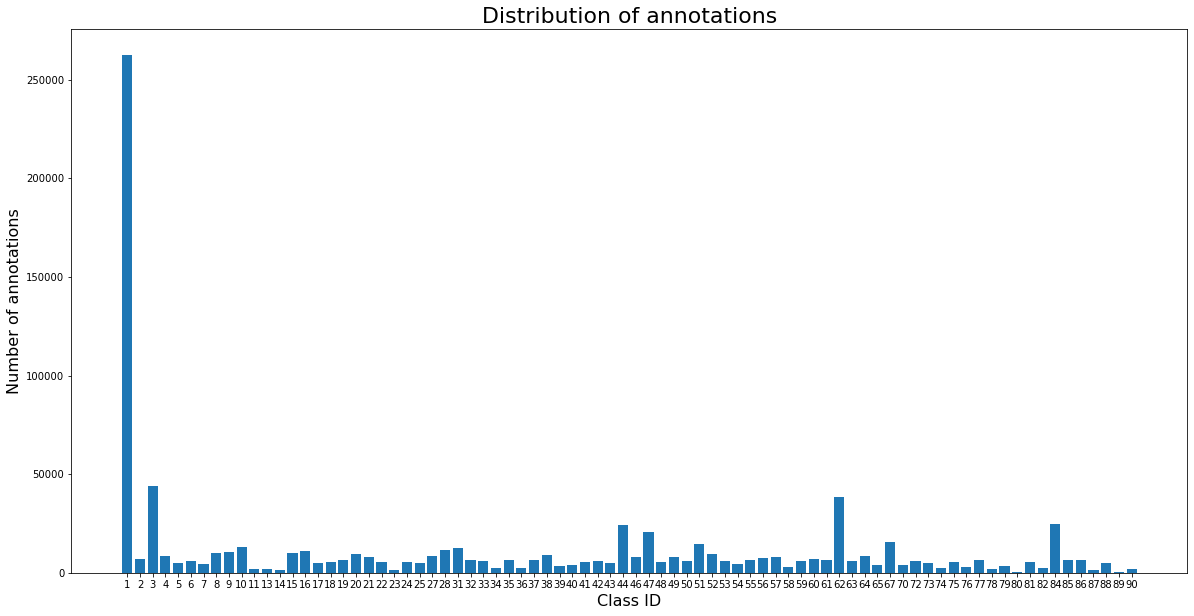

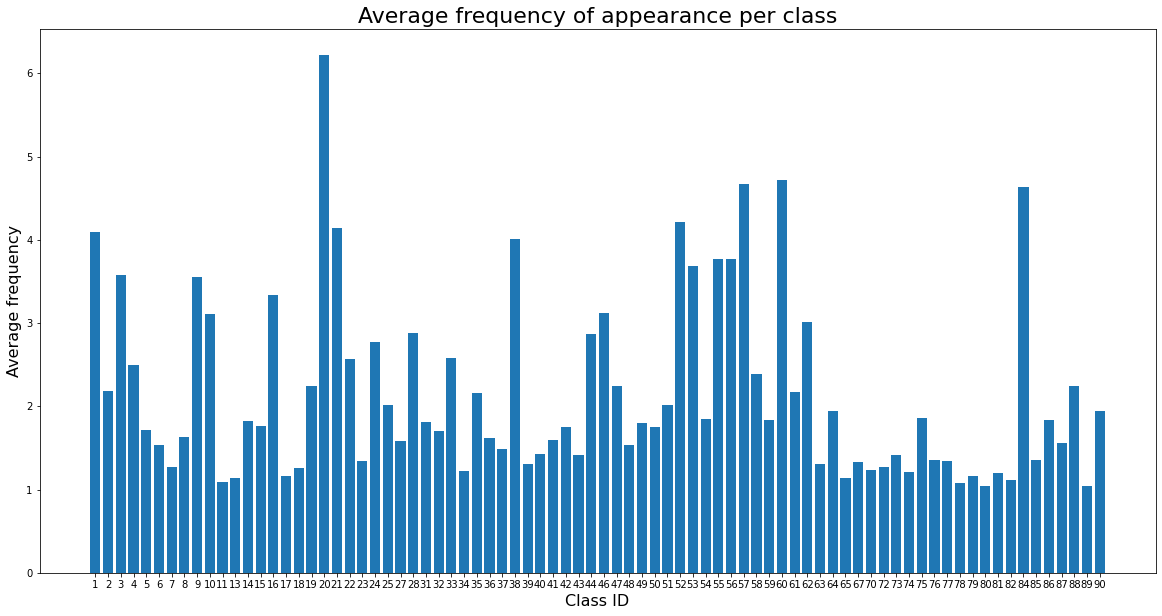

In [21]:
print(coco.loadAnns(coco.getAnnIds(catIds=1)[0])[0])
subcat_indices = []
subcat_names = []
subcat_annotation_counts = []
for name in supercat_names:
    s_ids = coco.getCatIds(supNms=name)
    subcat_indices.extend(s_ids)
    subcat_names.extend([c["name"] for c in coco.loadCats(s_ids)])
    subcat_annotation_counts.extend([len(coco.getAnnIds(catIds=id)) for id in s_ids])
    
subcat_indices, subcat_names, subcat_annotation_counts = zip(*sorted(zip(subcat_indices, subcat_names, subcat_annotation_counts), key=lambda x: x[0]))

    
assert len(subcat_indices) == len(subcat_annotation_counts), f"{len(subcat_ids)}, {len(subcat_annotation_counts)}"
assert len(subcat_indices) == len(subcat_names), f"{len(subcat_ids)}, {len(subcat_names)}"

plt.figure(figsize=(20, 10))
plt.title("Distribution of annotations", fontsize=22)
plt.bar([str(x) for x in subcat_indices], subcat_annotation_counts)
plt.xlabel("Class ID", fontsize=16)
plt.ylabel("Number of annotations", fontsize=16)
plt.savefig(os.path.join(PLOT_DIR, f"coco_{dataType}_dist_ann"))


plt.figure(figsize=(20, 10))
plt.title("Average frequency of appearance per class", fontsize=22)
plt.bar([str(x) for x in subcat_indices], [ann/img for ann, img in zip(subcat_annotation_counts, subcat_image_counts)])
plt.xlabel("Class ID", fontsize=16)
plt.ylabel("Average frequency", fontsize=16)
plt.savefig(os.path.join(PLOT_DIR, f"coco_{dataType}_freq"))